In [180]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
import nltk
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score,hamming_loss
import numpy as np
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
import SMOTE

[nltk_data] Downloading package punkt to C:\Users\zxc
[nltk_data]     ghoul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: No module named 'SMOTE'

In [118]:
from sklearn.model_selection import GridSearchCV

In [ ]:
db_name = 'recipe.db'
conn = sqlite3.connect(db_name)

table_name = 'recipe'

#забираем доступные категории
categories_sql = f"select c.id from category c " \
                 f"join recipe_categories rc on " \
                 f"c.id = rc.cat_id " \
                 f"GROUP by c.id " \
                 f"HAVING count(*) > 100 " \
                 f"ORDER BY c.id"

#забираем способ приготовления рецепта с категориями из доступных с id категорий
sql = f"SELECT r.manual, (SELECT group_concat(rc.cat_id , ', ') " \
      f"from recipe_categories rc " \
      f"WHERE rc.recipe_id = r.id AND " \
      f"rc.cat_id in ({categories_sql})" \
      f") AS categories from recipe r"

loaded_data = pd.read_sql(sql, conn)
loaded_categories = pd.read_sql(categories_sql, conn)
#pandas data frame
conn.close()

In [ ]:
loaded_categories

In [ ]:
#print(loaded_categories.id)

ids_cat = []
for i in range(len(loaded_categories)):
    ids_cat.append(str(loaded_categories.id[i]))

print(ids_cat)

In [ ]:
for i in range(len(ids_cat)):
    val = []
    for j in range(len(loaded_data)):
        spl = str(loaded_data.categories[j]).split(', ')
        #print(spl)
        #print(int(str(ids_cat[i]) in spl))
        val.append(int(str(ids_cat[i]) in spl))
    loaded_data.insert(loc=len(loaded_data.columns) , column=ids_cat[i], value=val)
#print(val)

In [ ]:
loaded_data.dtypes

In [ ]:
#делим dataset на тренировочный и тестовый
x_train,x_test,y_train,y_test = train_test_split(loaded_data["manual"], loaded_data[ids_cat],test_size=0.3,random_state=42)

In [ ]:
x_train

In [ ]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [ ]:
example = loaded_data.iloc[1]["manual"]
print(example)
print("------------------------")
print(tokenize_sentence(example))

In [158]:
#hyperparams
# Определение гиперпараметров для каждого компонента модели
tfidf_params = {
    'vectorizer__tokenizer': [lambda x: tokenize_sentence(x, remove_stop_words=True)],
    'vectorizer__max_features': [500, 1000, 2000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__use_idf': [True, False],
    # Другие гиперпараметры...
}
normalizer_params = {
    'normalizer__norm': ['l1', 'l2'],  # Тип нормализации (l2 - евклидова норма)
    # Другие гиперпараметры...
}

random_forest_params = {
    'model__estimator__n_estimators': [50, 100, 200],
    'model__estimator__max_depth': [None, 5, 10],
    'model__estimator__min_samples_split': [2, 5, 10],
    # Другие гиперпараметры...
}

In [121]:
tfidf = TfidfVectorizer()

Xfeatures = tfidf.fit_transform(x_train).toarray()

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [122]:
Xfeatures

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07412591,
        0.        ],
       ...,
       [0.09359784, 0.12076173, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [176]:
binary_rel_clf = BinaryRelevance(MultinomialNB()) #our model
binary_rel_clf.fit(Xfeatures, y_train)

#старая версия

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [175]:
model_pipeline = Pipeline([
    ("vectorizer",  TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("normalizer", Normalizer()),
    ("model", OneVsRestClassifier(RandomForestClassifier()))
]
)
model_pipeline.fit(x_train, y_train)
accuracy_score(y_test,model_pipeline.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.0771796093377799

In [174]:
random_model = Pipeline([
    ("vectorizer",  TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("normalizer", Normalizer()),
    ("model", RandomForestClassifier())
]
)
random_model.fit(x_train, y_train)
accuracy_score(y_test,random_model.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.07670319199618866

In [169]:
linear_model = Pipeline([
    ("vectorizer",  TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("normalizer", Normalizer()),
    ("model", OneVsRestClassifier(LinearSVC()))
]
)
linear_model.fit(x_train, y_train)
accuracy_score(y_test,linear_model.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress th

0.17246307765602667

In [128]:
test_text = "Выпечка"

model_pipeline.predict_proba([test_text])

array([[0.12, 0.13, 0.  , 0.01, 0.  , 0.02, 0.  , 0.02, 0.  , 0.01, 0.  ,
        0.  , 0.03, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.17, 0.03, 0.  ,
        0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [129]:
accuracy_score(y_test,model_pipeline.predict(x_test))

0.09623630300142925

In [130]:
precision_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6875200873054429

In [131]:
recall_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test))

0.2318448353631033

In [132]:
y_score = model_pipeline.predict_proba(x_test)
print(y_score)

[[0.13 0.02 0.   ... 0.04 0.02 0.  ]
 [0.15 0.   0.   ... 0.01 0.01 0.  ]
 [0.5  0.07 0.   ... 0.02 0.   0.01]
 ...
 [0.   0.   0.01 ... 0.   0.   0.  ]
 [0.15 0.08 0.11 ... 0.08 0.06 0.02]
 [0.2  0.13 0.05 ... 0.03 0.06 0.01]]


In [113]:
print(y_score[:, 0])

[0.16 0.16 0.36 ... 0.   0.26 0.25]


In [ ]:
y_test['1']

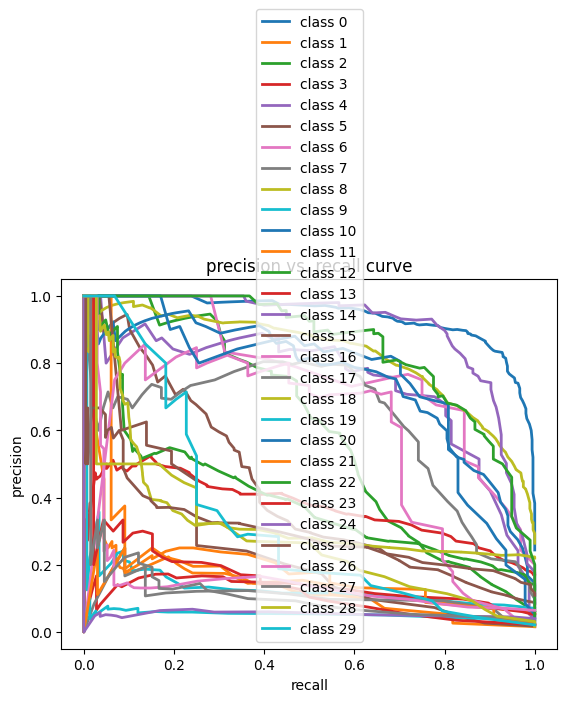

In [133]:
# precision recall curve
precision = dict()
recall = dict()

for i in range(len(ids_cat)):
    precision[i], recall[i], _ = precision_recall_curve(y_true=y_test[ids_cat[i]],
                                                        probas_pred=y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [157]:
#оценка гиперпараметров

grid_search = RandomizedSearchCV(model_pipeline, param_distributions={
    **tfidf_params,
    **normalizer_params,
    **random_forest_params
}, scoring='f1', cv=5, n_iter=2)

grid_search.fit(x_train, y_train)

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklear

KeyboardInterrupt: 

In [ ]:
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

y_pred = best_model.predict_prob(x_test)